# **CNN using Keras on custom data**

Gathered this data from google images - tiger, bear, koala and fox images, a total of 621 images

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
BASE_DIR = "/content/drive/MyDrive/258_image_data"

In [ ]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image

In [ ]:
images = []
labels = []

for file in os.listdir(BASE_DIR):
  if file == 'bear':
    for c in os.listdir(os.path.join(BASE_DIR, file)):
      images.append(c)
      labels.append('bear')
  if file == 'tiger':
    for c in os.listdir(os.path.join(BASE_DIR, file)):
      images.append(c)
      labels.append('tiger')
  if file == 'koala':
    for c in os.listdir(os.path.join(BASE_DIR, file)):
      images.append(c)
      labels.append('koala')
  if file == 'fox':
    for c in os.listdir(os.path.join(BASE_DIR, file)):
      images.append(c)
      labels.append('fox')

data = {'img':images, 'label':labels}
df = pd.DataFrame(data)
df.head()

,img,label
0,a_070.jpg,bear
1,a_061.jpg,bear
2,a_062.jpg,bear
3,a_060.jpg,bear
4,a_059.jpg,bear


In [ ]:
df['binary_label'] = LabelEncoder().fit_transform(df['label'])
df.head()

,img,label,binary_label
0,a_070.jpg,bear,0
1,a_061.jpg,bear,0
2,a_062.jpg,bear,0
3,a_060.jpg,bear,0
4,a_059.jpg,bear,0


## **Image classification on custom data using Keras**

In [ ]:
import keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# removing corrupt images 
import os

num_skipped = 0
for folder_name in ("bear", "tiger"):
    folder_path = os.path.join(BASE_DIR, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [ ]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    BASE_DIR,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    BASE_DIR,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 621 files belonging to 4 classes.
Using 497 files for training.
Found 621 files belonging to 4 classes.
Using 124 files for validation.


## **Visualization**

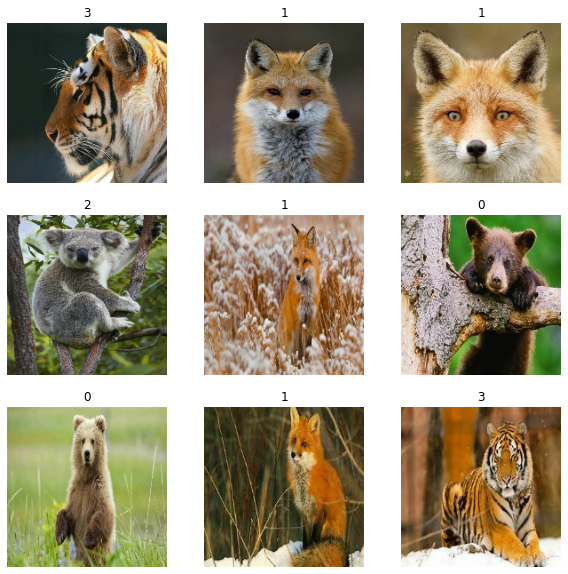

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## **Data Augmentation**

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

## **Augmented data visualization**

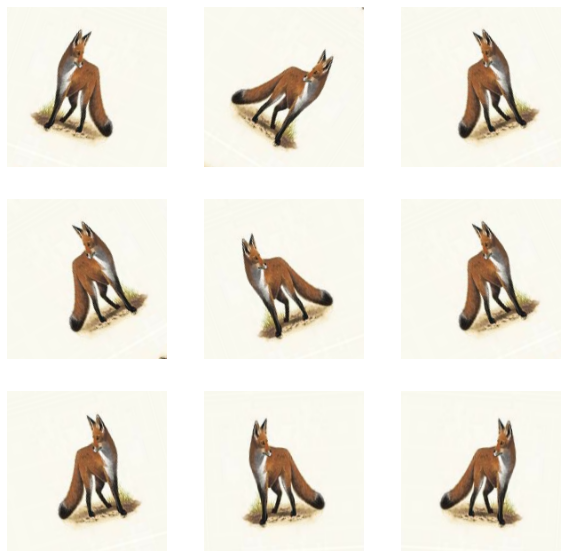

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


In [ ]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

## **Building the model**

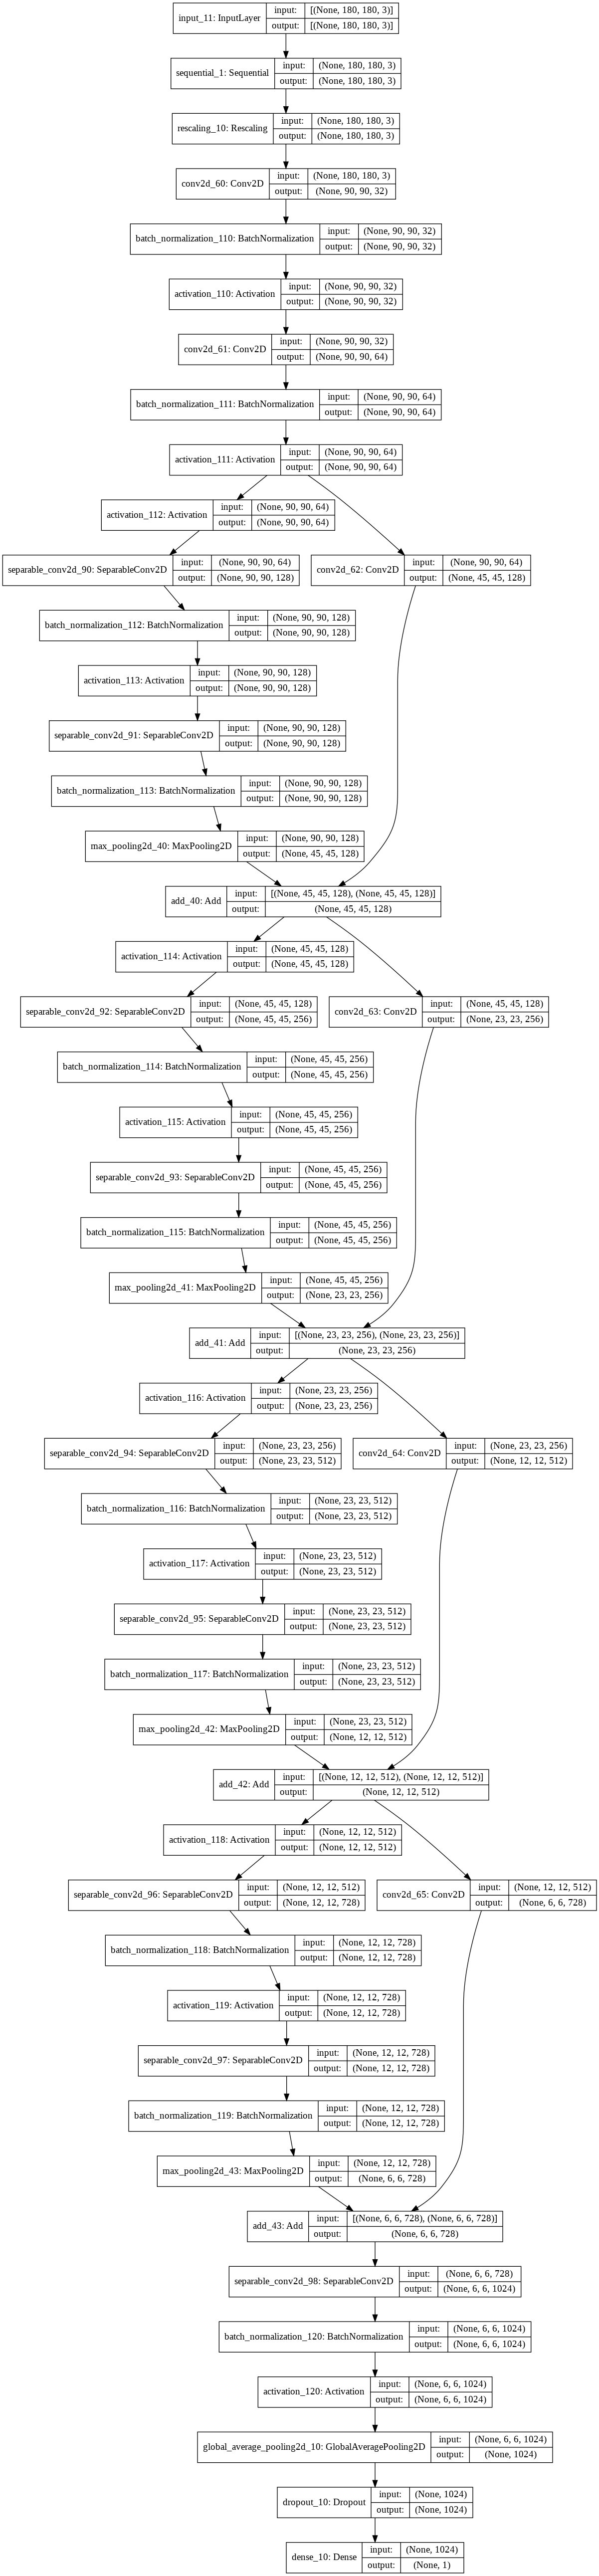

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    num_classes == 4
    activation = "softmax"
    units = 1

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=4)
keras.utils.plot_model(model, show_shapes=True)

## **Training the model**

In [ ]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/10
16/16 [==============================] - 149s 9s/step - loss: 0.0000e+00 - accuracy: 0.3419 - val_loss: 0.0000e+00 - val_accuracy: 0.2903
Epoch 2/10
16/16 [==============================] - 134s 8s/step - loss: 0.0000e+00 - accuracy: 0.3068 - val_loss: 0.0000e+00 - val_accuracy: 0.2903
Epoch 3/10
16/16 [==============================] - 134s 8s/step - loss: 0.0000e+00 - accuracy: 0.3151 - val_loss: 0.0000e+00 - val_accuracy: 0.2903
Epoch 4/10
16/16 [==============================] - 134s 8s/step - loss: 0.0000e+00 - accuracy: 0.3370 - val_loss: 0.0000e+00 - val_accuracy: 0.2903
Epoch 5/10
16/16 [==============================] - 134s 8s/step - loss: 0.0000e+00 - accuracy: 0.3156 - val_loss: 0.0000e+00 - val_accuracy: 0.2903
Epoch 6/10
16/16 [==============================] - 133s 8s/step - loss: 0.0000e+00 - accuracy: 0.3151 - val_loss: 0.0000e+00 - val_accuracy: 0.2903
Epoch 7/10
16/16 [==============================] - 133s 8s/step - loss: 0.0000e+00 - accuracy: 0.3259 - v